In [1]:
import yfinance as yf
import pandas as pd
import numpy as np
import datetime
import matplotlib.pyplot as plt
from sqlalchemy import create_engine, types

# Establish a connection to the SQL Server database
server = 'server'  # Replace 'your_server_name' with your SQL Server instance name
database = 'database'  # Replace 'your_database_name' with your database name
username = 'username'  # Replace 'your_username' with your SQL Server username
password = 'password'  # Replace 'your_password' with your SQL Server password
driver = 'ODBC Driver 17 for SQL Server'  # Replace with your SQL Server driver (e.g., 'ODBC+Driver+17+for+SQL+Server')


START = datetime.datetime(2020, 1, 1)
END = datetime.datetime(2024, 10, 2)
YEARS = (END - START).days / 365.25

price = yf.download('NVDA', start=START, end=END)

price.reset_index(inplace=True)


price.columns

[*********************100%%**********************]  1 of 1 completed


Index(['Date', 'Open', 'High', 'Low', 'Close', 'Adj Close', 'Volume'], dtype='object')

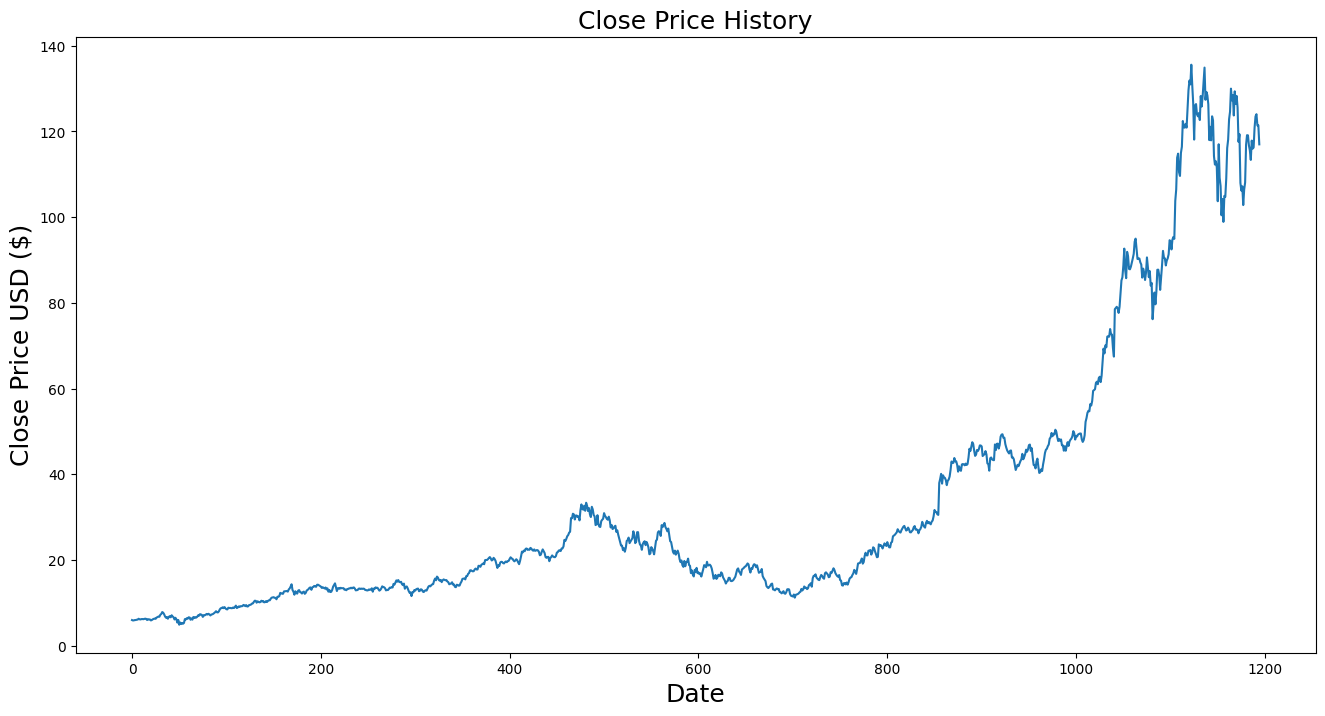

In [2]:
plt.figure(figsize=(16, 8))
plt.title('Close Price History', fontsize=18)
plt.plot(price['Close'])
plt.xlabel('Date', fontsize=18)
plt.ylabel('Close Price USD ($)', fontsize=18)
plt.show()

In [3]:
##SMA Simple Moving Average

PERIOD200 = 200
PERIOD50 = 50

def SMA (price, PERIOD, column='Close'):
    return price[column].rolling(window=PERIOD).mean()

price['SMA_200'] = SMA(price, PERIOD200)
price['SMA_50'] = SMA(price, PERIOD50)

In [4]:
price['Signal'] = pd.NA 

for i in range(1, len(price)):
    if price['SMA_50'].iloc[i] > price['SMA_200'].iloc[i] and price['SMA_50'].iloc[i - 1] <= price['SMA_200'].iloc[i - 1]:
        price.loc[price.index[i], 'Signal'] = 'Buy'
    elif price['SMA_50'].iloc[i] < price['SMA_200'].iloc[i] and price['SMA_50'].iloc[i - 1] >= price['SMA_200'].iloc[i - 1]:
        price.loc[price.index[i], 'Signal'] = 'Sell'

price['Signal'] = price['Signal'].ffill()

In [5]:
price['Buy'] = (price['Signal'] == 'Buy')
price['Sell'] = (price['Signal'] == 'Sell')

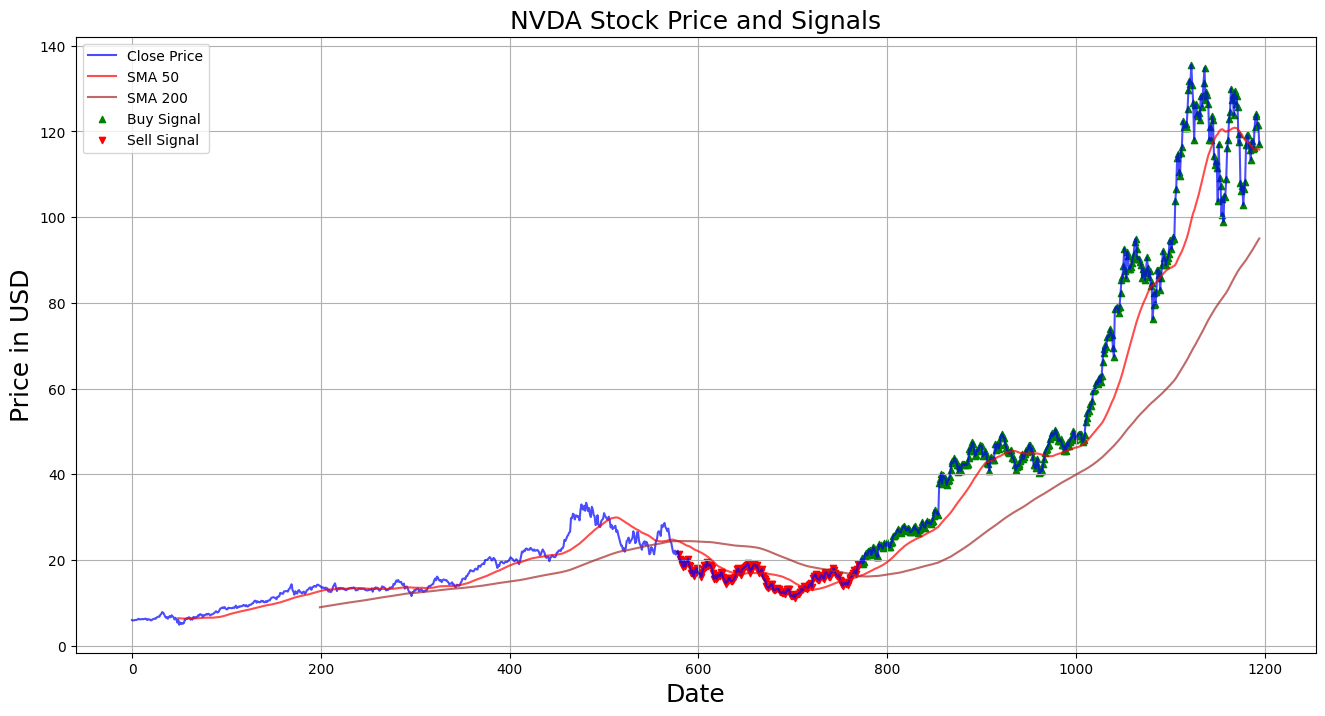

In [6]:
plt.figure(figsize=(16, 8))
plt.title('NVDA Stock Price and Signals', fontsize=18)

plt.plot(price.index, price['Close'], label='Close Price', color='blue', alpha=0.7)
plt.plot(price.index, price['SMA_50'], label='SMA 50', color='red', alpha=0.7)
plt.plot(price.index, price['SMA_200'], label='SMA 200', color='brown', alpha=0.7)

plt.scatter(price.index[price['Buy']], price['Close'][price['Buy']], marker='^', color='green', label='Buy Signal', s=20)

plt.scatter(price.index[price['Sell']], price['Close'][price['Sell']], marker='v', color='red', label='Sell Signal', s=20)

plt.xlabel('Date', fontsize=18)
plt.ylabel('Price in USD', fontsize=18)
plt.legend()
plt.grid()
plt.show()

In [7]:
STARTING_MONEY = 10000
how_many = STARTING_MONEY // price['Close'].iloc[0]  
balance = STARTING_MONEY - (how_many * price['Close'].iloc[0])

for i in range(len(price)):
    if price['Signal'].iloc[i] is not pd.NA:
        if price['Signal'].iloc[i] == 'Buy':
            shares_to_buy = balance // price['Close'].iloc[i]
            if shares_to_buy > 0:
                how_many += shares_to_buy
                balance -= shares_to_buy * price['Close'].iloc[i]

        elif price['Signal'].iloc[i] == 'Sell':
            if how_many > 0:
                balance += how_many * price['Close'].iloc[i]
                how_many = 0

if how_many > 0:
    balance += how_many * price['Close'].iloc[-1]

print("Final Balance:", balance)
print("Shares Remaining:", how_many)

Final Balance: 217403.87679338455
Shares Remaining: 1858.0


In [8]:
how_manny = STARTING_MONEY // price['Close'].iloc[0]

balance_without_moving_average = STARTING_MONEY - (how_many * price['Close'].iloc[0])

balance_without_moving_average = balance_without_moving_average + how_many * price['Close'].iloc[-1]

print(balance_without_moving_average)
print(how_manny)

216242.18086147308
1667.0


In [9]:
# Define the connection string
conn_str = f'mssql+pyodbc://{username}:{password}@{server}/{database}?driver={driver}'

# Create a SQLAlchemy engine
engine = create_engine(conn_str)

# Specify the table name
table_name = 'Bitcoin_Data'  # Replace 'YourTableName' with your table name

# Define SQL Server data types for each column (adjust as per your data types)
dtype = {
    'Date': types.DateTime(),
    'Open': types.Float(),
    'High': types.Float(),
    'Low': types.Float(),
    'Close': types.Float(),
    'Adj Close': types.Float(),
    'Volume': types.BigInteger(),  # Use BigInteger for large numbers like Volume
}

# Upload the DataFrame to the SQL Server database table, excluding 'day_date' column
price[['Date', 'Open', 'High', 'Low', 'Close', 'Adj Close', 'Volume']].to_sql(table_name, con=engine, if_exists='replace', index=False, dtype=dtype)


#Open	High	Low	Close	Adj Close	Volume

# Close the SQLAlchemy engine
engine.dispose()

print("Data has been successfully uploaded to the SQL Server database.")

Data has been successfully uploaded to the SQL Server database.
